In [60]:
import numpy as np
import scipy.integrate as integrate
import scipy.special as sp
import matplotlib.pyplot as plt
import pyccl as ccl
from matplotlib import rc
import astropy.cosmology as cosmo
from astropy.constants import c
from astropy import units as u
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

In [61]:
l_max = 5000
f_sky = 0.1392
sky_area = f_sky * 4 * np.pi #units in steradians here
sky_area = 4
print(sky_area)

4


Defining some iteration functions

In [62]:
def iter_unique_pairs(items1, items2=None, upper_triangle=False):
    """Generator function to iterate over  pairs for two lists."""
    counter = 0
    if items2 is None:
        items2 = items1  # If only one list is provided, iterate over unique pairs within it

    seen_pairs = set()
    for i, item1 in enumerate(items1):
        for j, item2 in enumerate(items2):
            if upper_triangle and items1 in items2 and j < i:
                continue  # skips lower triangle 
            if (item1, item2) in seen_pairs or (item2, item1) in seen_pairs:
                continue  # Skip duplicate pairs
            seen_pairs.add((item1, item2))
            yield counter, i, j, item1, item2
            counter += 1

def iter_auto_pairs(items1, items2=None, upper_triangle=True):
    """Generator function to iterate over  pairs for two lists.
    
    If upper_triangle is True and items1 == items2, it iterates only over the upper triangle including the diagonal.
    Otherwise, it iterates over all auto pairs."""
    counter = 0
    if items2 is None:
        items2 = items1  # If only one list is provided, iterate over unique pairs within it

    for i in range(items1):
        for j in range(i,items2):
            yield counter, i, i, j, j
            counter += 1

Get n(z) values for C_ells 

In [63]:
all_nzs = np.array([np.loadtxt(f"/home/anya/BAO/DESI_Y1/outputs/EZmocks/nz_EZmock_{i+1}.txt")[:,1] for i in range(1000)])
z_centers = np.array(np.loadtxt(f"/home/anya/BAO/DESI_Y1/outputs/EZmocks/nz_EZmock_1.txt")[:,0])
#theta_max = np.max(theta)
#theta_min = np.min(theta)

mean_nzs = np.mean(all_nzs, axis = 0)

print("shape of nzs:",all_nzs.shape)
print("shape of mean of nzs:", mean_nzs.shape)
#print("shape of theta:", theta.shape)
print("this is mean nz:", mean_nzs)
#print("this is theta:", theta)

shape of nzs: (1000, 29)
shape of mean of nzs: (29,)
this is mean nz: [38651.287 40816.448 43222.751 45911.536 48364.986 51444.071 55002.416
 58338.858 61553.379 64734.774 67144.04  69502.696 71285.675 72993.042
 74546.779 76563.445 79564.693 83703.254 89354.272 93223.103 94920.718
 93396.367 89461.935 84756.019 78801.653 72570.142 65550.045 57939.366
 50234.635]


Reconstructing theta bin edges!

In [64]:
min_sep = 0.01
max_sep = 10.0
bin_size = 0.4
n_bins = (max_sep - min_sep)/bin_size
theta_edges = np.linspace(min_sep, max_sep, round(n_bins) + 1)

# Convert theta values from degrees to radians
theta_min_rad = np.radians(theta_edges[:-1])  # Lower edges of bins
theta_max_rad = np.radians(theta_edges[1:]) 

n_bars = mean_nzs / sky_area #for the covariance not the C_ells
print(n_bars)

[ 9662.82175 10204.112   10805.68775 11477.884   12091.2465  12861.01775
 13750.604   14584.7145  15388.34475 16183.6935  16786.01    17375.674
 17821.41875 18248.2605  18636.69475 19140.86125 19891.17325 20925.8135
 22338.568   23305.77575 23730.1795  23349.09175 22365.48375 21189.00475
 19700.41325 18142.5355  16387.51125 14484.8415  12558.65875]


Compute C_ells 


In [65]:
cosmo = ccl.CosmologyVanillaLCDM(matter_power_spectrum="halofit")

def _compute_cls_(z_centers, ell_max = l_max, has_rsd = True, do_limber = True):
    l_limber = None
    l_limber = -1 if do_limber else 1e6

    # Define bin edges (as bins are centered on provided z values)
    z_edges = np.concatenate(([z_centers[0] - 0.01], (z_centers[:-1] + z_centers[1:]) / 2, [z_centers[-1] + 0.01]))

    # Create one tracer per redshift bin
    tracers = []

    for i in range(len(z_centers)):
        # Define a finer sampling of z within the bin
        z_bin = np.linspace(z_edges[i], z_edges[i+1], 100)  
        
        # Define the top-hat function for n(z)
        X = 1 / (z_edges[i+1] - z_edges[i])  # Normalization for top-hat
        n_bin = np.where((z_bin >= z_edges[i]) & (z_bin <= z_edges[i+1]), X, 0.0)  
        
        # Create a tracer for this bin with bias=2
        tracer = ccl.NumberCountsTracer(
            cosmo,
            dndz=(z_bin, n_bin),
            has_rsd=True,
            bias=(z_bin, 2 * np.ones_like(z_bin))
        )
        tracers.append(tracer)

    # Define ell range
    ell = np.arange(2, ell_max)  # Set ell range

    # Compute full C_ell matrix (auto- and cross-correlations)
    n_bins = len(tracers)
    print(n_bins)

    # Compute C_ell for upper-triangle only
    cl_values = [ccl.angular_cl(cosmo, tracers[i], tracers[j], ell, l_limber= l_limber)
                for _, i, j, _ , _ in iter_unique_pairs(range(n_bins), upper_triangle=True)]

    cl_matrix = np.zeros((n_bins, n_bins, len(ell)))
    for idx,(_, i, j, _, _) in enumerate(iter_unique_pairs(range(n_bins), upper_triangle=True)):
        cl_matrix[i, j, :] = cl_values[idx]  # Upper triangle
        if i != j:
            cl_matrix[j, i, :] = cl_values[idx]  # Fill lower triangle
    return cl_matrix

In [66]:
cells= _compute_cls_(z_centers)

29


<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_1849114/781093531.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.title("Angular Power Spectrum $C_\ell$ for DESI LRGs (Auto)")


Text(0.5, 1.0, 'Angular Power Spectrum $C_\\ell$ for DESI LRGs (Auto)')

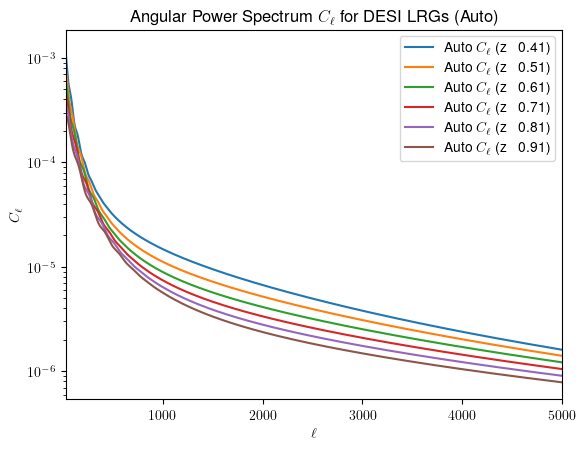

In [67]:
n_bins = cells.shape[0]
ell = np.arange(2, l_max)
for i in range(0, n_bins, 5):  # Plot every 5th bin
    plt.semilogy(ell, cells[i, i, :], label=f"Auto $C_\\ell$ (z ~ {z_centers[i]:.2f})",)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.legend()
plt.xlim(30,5000)
plt.title("Angular Power Spectrum $C_\ell$ for DESI LRGs (Auto)")

Compute covariance matrix!

In [68]:
def bin_averaged_legendre_ell(ell, theta_edges):
    """Compute the bin-averaged Legendre polynomial, Eq. 10 in arxiv:1801.04390"""
    theta_pairs = list(zip(theta_edges[:-1], theta_edges[1:])) #creates pairs of bin edges
    x_mins = np.zeros(len(theta_pairs))
    x_maxs = np.zeros(len(theta_pairs))

    for ith,th in enumerate(theta_pairs):
        x_mins[ith] = np.cos(np.radians(th[0]))
        x_maxs[ith] = np.cos(np.radians(th[1]))

    ell_plus_1 = ell[:,None] + 1
    ell_minus_1 = ell[:,None] - 1

    P_ell_xmin = sp.eval_legendre(ell_plus_1, x_mins) - sp.eval_legendre(ell_minus_1, x_mins)
    P_ell_xmax = sp.eval_legendre(ell_plus_1, x_maxs) - sp.eval_legendre(ell_minus_1, x_maxs)

    return np.array((P_ell_xmax - P_ell_xmin) / ((2*ell[:,None] + 1)*(x_maxs - x_mins))), x_mins, x_maxs
    

def compute_covariance_matrix(theta_edges, z_centers, ell, Cl_matrix, n_bar, f_sky):
    """Compute the covariance matrix for the autos of w(theta)"""

    num_theta_bins = len(theta_edges) - 1
    num_z_bins = len(z_centers)
    print(num_z_bins)
    cov_matrix = np.zeros((num_z_bins, num_z_bins,  num_theta_bins, num_theta_bins))
    
    P_l_theta, x_mins, x_maxs = bin_averaged_legendre_ell(ell, theta_edges)

    #shape of P_l_theta is (n_ell, n_theta)
    #n_bar will have shape of (n_z)
    #x_mins and x_maxs have shape of (n_theta)


    def kroncker_delta(i,j):
        delta = None
        delta = 1 if i == j else 0
        return delta
    
    
    for icl1, i, j, m, n in iter_auto_pairs(num_z_bins, upper_triangle=True):

        if m == i and n == j and i != j:
            print("this is the case we don't want")
            print(i,j,m,n)
            shot_noise_term = np.diag(1 /((8 * np.pi**2)*(f_sky * n_bar[i] * n_bar[j] * (x_mins - x_maxs))))
            #shot_noise_term currently has shape (num_theta)
            Cl_terms = Cl_matrix[i,i,:]*Cl_matrix[j,j,:] + Cl_matrix[i,j,:]**2 + Cl_matrix[i,i,:]/n_bar[j] + Cl_matrix[j,j,:]/n_bar[i]
            #Cl_terms currently has shape (n_ell)

            cov_value= np.einsum('l,l, lt, lT -> tT', (2*ell+1)/(f_sky * (4*np.pi)**2),  Cl_terms, P_l_theta, P_l_theta)
            #cov_value has shape (n_theta, n_theta)

            print(cov_value)

            cov_matrix[i,m,:, :] = shot_noise_term + cov_value 

        if m == i and n == j and i == j:
            print("this is the diagonal")
            print(i,j,m,n)
            shot_noise_term = np.diag(1 / ((4 * np.pi**2)*(f_sky * n_bar[i]**2 * (x_mins - x_maxs))))
            diag_term = 2 * Cl_matrix[i, i, :] / n_bar[i] + Cl_matrix[i,i,:]**2
            cov_value = np.einsum('l,l,lt,lT->tT', (2 * ell + 1) / (8 * np.pi**2 * f_sky), diag_term, P_l_theta, P_l_theta)
            cov_matrix[i, m, :, :] = shot_noise_term  + cov_value 

            print(cov_value)

        else:
            print(i,j,m,n)
            term_im = Cl_matrix[i, m, :] + (kroncker_delta(i,m)/n_bar[i])
            term_jn = Cl_matrix[j, n, :] + (kroncker_delta(j,n)/n_bar[j])
            term_in =Cl_matrix[i, n, :] + (kroncker_delta(i,n)/n_bar[i])
            term_jm =Cl_matrix[j, m, :] + (kroncker_delta(j,m)/n_bar[j])

            cl_terms = term_im*term_jn + term_in*term_jm

            cov_value = np.einsum('l,l,lt,lT->tT', (2 * ell + 1) / (16 * np.pi**2 * f_sky), cl_terms,
                                    P_l_theta, P_l_theta)
            print(cov_value)

            cov_matrix[i, m, :, :] = cov_value

        print(cov_matrix.shape)

        #Enforcing symmetry
        cov_matrix = 0.5 * (cov_matrix + np.swapaxes(cov_matrix, 0, 1))
        cov_matrix = 0.5 * (cov_matrix + np.swapaxes(cov_matrix, 2, 3))
    
    return cov_matrix

In [69]:
ell = np.arange(2,l_max)
cov = compute_covariance_matrix(theta_edges, z_centers, ell, cells, n_bars, f_sky)

29


this is the diagonal
0 0 0 0
[[ 6.22400281e-04  4.45614649e-04  3.21406274e-04  2.37329725e-04
   1.77133348e-04  1.33114154e-04  1.00548562e-04  7.62943620e-05
   5.81786880e-05  4.46766609e-05  3.46938435e-05  2.71182685e-05
   2.01785314e-05  1.25107715e-05  4.85203168e-06 -1.38234863e-06
  -5.75639892e-06 -8.53969273e-06 -1.01496115e-05 -1.09445273e-05
  -1.11904297e-05 -1.10722651e-05 -1.07188695e-05 -1.02256965e-05
  -9.66477488e-06]
 [ 4.45614649e-04  4.21824092e-04  3.20921265e-04  2.39092883e-04
   1.79526865e-04  1.35434700e-04  1.02578595e-04  7.79990155e-05
   5.95940183e-05  4.58495439e-05  3.55008210e-05  2.71215239e-05
   1.95081511e-05  1.22256517e-05  5.33753665e-06 -6.03262969e-07
  -5.05157690e-06 -8.00223126e-06 -9.76499298e-06 -1.06767263e-05
  -1.10054258e-05 -1.09461364e-05 -1.06376814e-05 -1.01795971e-05
  -9.64211465e-06]
 [ 3.21406274e-04  3.20921265e-04  3.07711444e-04  2.41663456e-04
   1.83771881e-04  1.39830512e-04  1.06527373e-04  8.13631629e-05
   6.2402

In [70]:
num_theta_bins = 25
num_z_bins = 29
cov =cov.transpose(0, 2, 1, 3).reshape((num_z_bins * num_theta_bins, num_z_bins * num_theta_bins))
np.savez("/home/anya/BAO/covariance/analytical_cov_test.npz", cov = cov)


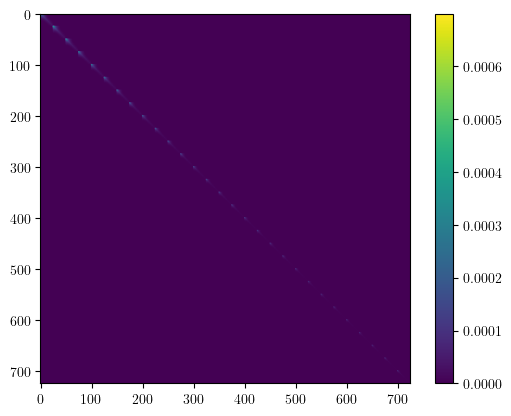

In [71]:
fig = plt.figure()
im = plt.imshow(cov, vmin =0)
fig.colorbar(im)

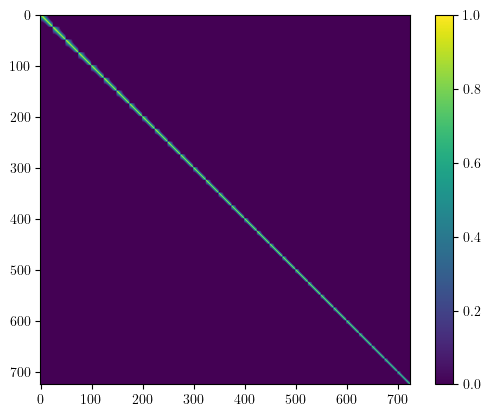

In [72]:
a_diag_cov = np.sqrt(np.diag(cov))  # Extract sqrt of diagonal elements
a_corr = cov / np.outer(a_diag_cov, a_diag_cov)  # Normalize

fig = plt.figure()
im = plt.imshow(a_corr, vmin =0)
fig.colorbar(im)